In [1]:
# Import stuff
import random, copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Set random seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# Create environment for One Turn Zombie Dice game

# Dice class
class Dice:
    def __init__(self, brains_count, feet_count, shots_count, color):
        self.brains_count = brains_count
        self.feet_count = feet_count
        self.shots_count = shots_count
        self.total = brains_count + feet_count + shots_count
        self.color = color
        
    def roll(self):
        n = np.random.randint(self.total)
        if n < self.brains_count:
            return 'brain'
        elif n < self.brains_count + self.feet_count:
            return 'feet'
        else:
            return 'shot'
        
# Cup class
class Cup:
    def __init__(self, green_dice_count=6, yellow_dice_count=4, red_dice_count=3):
        self.cup = []
        
        # Add green dice
        for _ in range(green_dice_count):
            self.cup.append(Dice(3, 2, 1, 'green'))
            
        # Add yellow dice
        for _ in range(yellow_dice_count):
            self.cup.append(Dice(2, 2, 2, 'yellow'))
            
        # Add red dice
        for _ in range(red_dice_count):
            self.cup.append(Dice(1, 2, 3, 'red'))
            
    def size(self):
        return len(self.cup)
        
    def shake(self):
        random.shuffle(self.cup)
        
    def draw(self, n=3):
        # Draw n dice from the cup, or return None if there's not enough dice
        if self.size() < n:
            return None
        
        self.shake()
        result = []
        for _ in range(n):
            result.append(self.cup[-1])
            del self.cup[-1]
        return result
            
    def refill(self, dice_refill):
        # Refill the cup with some dice
        for dice in dice_refill:
            self.cup.append(dice)
            
# Utility function to count number of dice by color
def count_color(dice_list):
    green_count, yellow_count, red_count = 0, 0, 0
    for dice in dice_list:
        if dice.color is 'green':
            green_count += 1
        elif dice.color is 'yellow':
            yellow_count += 1
        else:
            red_count += 1
    return (green_count, yellow_count, red_count)
            
# Game environment class
class OneTurnZombieDice:
    def __init__(self):
        self.cup = Cup()
        self.hand = []
        self.brains = []
        self.feet = []
        self.shots = []
        self.n_actions = 2
        self.score = 0
        
    def get_state(self):
        # Return numbers of green, yellow, and red dice in each slot
        return (*count_color(self.cup.cup),
                *count_color(self.brains),
                *count_color(self.feet),
                *count_color(self.shots))
    
    def reset(self):
        self.__init__()
        return self.get_state()
    
    def step(self, action):
        state, reward, done, info = self.get_state(), 0, False, None
        
        if action == 0:
            # End game, return total number of brains obtained as score
            reward = self.score + len(self.brains)
            done = True
        else:
            # Draw dice and roll
            # Reroll dice that got feet
            for dice in self.feet:
                self.hand.append(dice)
            self.feet = []
            
            # Fill hand by drawing from the cup
            drawn_dice = self.cup.draw(3 - len(self.hand))
            if drawn_dice is None:
                # Not enough dice in cup, refill it
                self.score += len(self.brains)
                self.cup.refill(self.brains)
                self.brains = []
                drawn_dice = self.cup.draw(3 - len(self.hand))
            for dice in drawn_dice:
                self.hand.append(dice)
                
            # Roll dice
            for dice in self.hand:
                result = dice.roll()
                if result == 'brain':
                    self.brains.append(dice)
                elif result == 'feet':
                    self.feet.append(dice)
                else:
                    self.shots.append(dice)
                    # Check for game over
                    if len(self.shots) >= 3:
                        done = True
            self.hand = []
            
            state = self.get_state()
            
        return (state, reward, done, info)

In [3]:
# Policy network class
class PolicyNetwork(nn.Module):
    def __init__(self, n_inputs, hidden_size, n_outputs):
        super().__init__()
        self.fc1 = nn.Linear(n_inputs, hidden_size)
        self.fc2 = nn.Linear(hidden_size, n_outputs)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Agent class
class Agent:
    def __init__(self, hidden_size=36, learning_rate=1e-3):
        self.policy = PolicyNetwork(12, hidden_size, 2).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
        
    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float, device=device).unsqueeze(0)
        probs = F.softmax(self.policy(state), dim=1)
        action = np.random.choice(2, p=probs.cpu().detach().numpy().ravel())
        log_prob = torch.log(probs[0, action])
        return (action, log_prob)
    
    def get_probs(self, state):
        with torch.no_grad():
            state = torch.tensor(state, dtype=torch.float, device=device).unsqueeze(0)
            probs = F.softmax(self.policy(state), dim=1)
        return probs
    
    def update_parameters(self, all_rewards, all_log_probs, discount_rate=0.9):
        # Compute discounted rewards
        all_discounted_rewards = []
        for rewards in all_rewards:    
            total_reward = 0
            discounted_rewards = [0] * len(rewards)
            for i in reversed(range(len(rewards))):
                discounted_rewards[i] = rewards[i] + discount_rate * total_reward
                total_reward = discounted_rewards[i]
            all_discounted_rewards.append(discounted_rewards)

        # Stack all rewards and log-probs
        flat_discounted_rewards = [r for rewards in all_discounted_rewards for r in rewards]
        flat_log_probs = [lp for log_probs in all_log_probs for lp in log_probs]
        
        # Convert to tensors
        discounted_rewards = torch.tensor(flat_discounted_rewards).to(device)
        log_probs = torch.stack(flat_log_probs).to(device)
        
        # Normalize rewards. This speeds up training by reducing variance.
        normalized_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)
        
        # Reset parameter gradients
        self.optimizer.zero_grad()
        
        # Get "loss". This isn't the actual loss function, but its gradient matches the
        # gradient of the actual loss function.
        loss = torch.mul(normalized_rewards, -log_probs).sum()
        
        # Perform back-propagation
        loss.backward()
        
        # Optimize
        self.optimizer.step()

In [4]:
# Save model?

# Initialize environment and agent
env = OneTurnZombieDice()
agent = Agent()

# Track average scores
avg_scores = []

# Training hyperparameters
n_epochs = 5000
episodes_per_epoch = 50
discount_rate = 0.9
print_interval = 100

# Training loop
for epoch in range(n_epochs):
    all_rewards = []  # This 2D reward array is really ugly, consider changing it to 1D only
    all_log_probs = []
    avg_score = 0
    
    for episode in range(episodes_per_epoch):
        rewards = []
        log_probs = []
        score = 0
        
        # Collect trajectory
        state = env.reset()
        done = False
        while not done:
            action, log_prob = agent.get_action(state)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            log_probs.append(log_prob)
            score += reward
            
        all_rewards.append(rewards)
        all_log_probs.append(log_probs)
        avg_score += score
        
    # Update agent parameters
    agent.update_parameters(all_rewards, all_log_probs, discount_rate)
    
    # Record average score
    avg_score /= episodes_per_epoch
    avg_scores.append(avg_score)
    
    if epoch % print_interval == 0:
        print("Epoch {}: {}".format(epoch, avg_score))

Epoch 0: 0.46
Epoch 100: 1.84
Epoch 200: 1.52
Epoch 300: 2.26
Epoch 400: 1.9
Epoch 500: 2.38
Epoch 600: 1.9
Epoch 700: 2.56
Epoch 800: 2.04
Epoch 900: 2.28
Epoch 1000: 2.66
Epoch 1100: 1.92
Epoch 1200: 1.96
Epoch 1300: 2.08
Epoch 1400: 2.34
Epoch 1500: 2.38
Epoch 1600: 1.84
Epoch 1700: 2.32
Epoch 1800: 2.48
Epoch 1900: 2.18
Epoch 2000: 2.24
Epoch 2100: 2.18
Epoch 2200: 1.94
Epoch 2300: 2.22
Epoch 2400: 2.18
Epoch 2500: 2.8
Epoch 2600: 1.94
Epoch 2700: 2.14
Epoch 2800: 1.98
Epoch 2900: 1.94
Epoch 3000: 2.36
Epoch 3100: 2.22
Epoch 3200: 2.58
Epoch 3300: 2.14
Epoch 3400: 2.2
Epoch 3500: 1.96
Epoch 3600: 1.82
Epoch 3700: 2.44
Epoch 3800: 2.12
Epoch 3900: 2.5
Epoch 4000: 2.18
Epoch 4100: 1.94
Epoch 4200: 2.56
Epoch 4300: 2.1
Epoch 4400: 2.46
Epoch 4500: 2.46
Epoch 4600: 1.94
Epoch 4700: 2.2
Epoch 4800: 1.8
Epoch 4900: 2.1


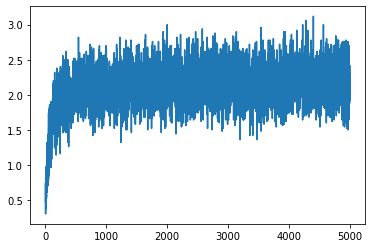

In [5]:
plt.plot(avg_scores)

In [6]:
# Function to simulate one episode
def simulate(env, agent, detailed=False):
    state = env.reset()
    if detailed:
        print(state)
    score = 0
    done = False
    while not done:
        action, _ = agent.get_action(state)
        if detailed:
            probs = agent.get_probs(state)
            print(probs.cpu().numpy(), action)
        state, reward, done, _ = env.step(action)
        if detailed:
            print(state)
        score += reward
    return score

Counts: [28751, 10451, 15100, 19562, 15684, 7142, 2513, 663, 119, 15, 0, 0]
Ratio: [0.28751, 0.10451, 0.151, 0.19562, 0.15684, 0.07142, 0.02513, 0.00663, 0.00119, 0.00015, 0.0, 0.0]
Mean: 2.18589


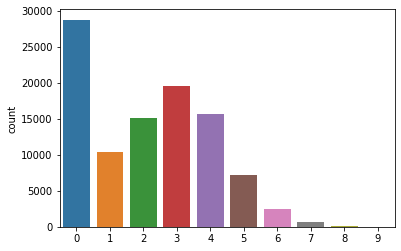

In [7]:
# Plot score distribution
results = []
counts = [0] * 12
n = 100000
for _ in range(n):
    score = simulate(env, agent)
    results.append(score)
    counts[score] += 1
print("Counts:", counts)
print("Ratio:", [count / n for count in counts])
print("Mean:", sum(results) / n)
sns.countplot(results)

In [8]:
for _ in range(10):
    print("=== NEW GAME ===")
    score = simulate(env, agent, detailed=True)
    print("Score:", score)

=== NEW GAME ===
(6, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
[[1.0681913e-09 1.0000000e+00]] 1
(3, 4, 3, 2, 0, 0, 1, 0, 0, 0, 0, 0)
[[9.7049463e-07 9.9999905e-01]] 1
(3, 3, 2, 3, 0, 0, 0, 0, 0, 0, 1, 1)
[[9.9998903e-01 1.0931855e-05]] 0
(3, 3, 2, 3, 0, 0, 0, 0, 0, 0, 1, 1)
Score: 3
=== NEW GAME ===
(6, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
[[1.0681913e-09 1.0000000e+00]] 1
(5, 3, 2, 1, 0, 0, 0, 1, 1, 0, 0, 0)
[[6.5969266e-07 9.9999928e-01]] 1
(4, 3, 2, 2, 0, 0, 0, 0, 1, 0, 1, 0)
[[0.26744193 0.7325581 ]] 0
(4, 3, 2, 2, 0, 0, 0, 0, 1, 0, 1, 0)
Score: 2
=== NEW GAME ===
(6, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
[[1.0681913e-09 1.0000000e+00]] 1
(4, 3, 3, 0, 1, 0, 1, 0, 0, 1, 0, 0)
[[1.0086438e-05 9.9998987e-01]] 1
(3, 2, 3, 2, 2, 0, 0, 0, 0, 1, 0, 0)
[[0.99491066 0.00508933]] 0
(3, 2, 3, 2, 2, 0, 0, 0, 0, 1, 0, 0)
Score: 4
=== NEW GAME ===
(6, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
[[1.0681913e-09 1.0000000e+00]] 1
(4, 3, 3, 1, 1, 0, 1, 0, 0, 0, 0, 0)
[[2.8812707e-07 9.9999976e-01]] 1
(3, 3, 2, 1, 1, 0, 1, 0, 

In [11]:
# Compute probability of winning a 2-player game for all pairs of scores
def simulate_two_player_game(agent1, agent2, starting_score1=0, starting_score2=0, player2_move_first=False):
    env = OneTurnZombieDice()
    score1 = starting_score1
    score2 = starting_score2
    
    if player2_move_first:
        score2 += simulate(env, agent2)
    
    while True:
        if score1 >= 13 or score2 >= 13:
            if score1 > score2:
                return 1
            elif score1 < score2:
                return 2
            
        score1 += simulate(env, agent1)
        score2 += simulate(env, agent2)
        
win_probs_move1 = np.zeros((13, 13))
win_probs_move2 = np.zeros((13, 13))
trials_per_pair = 1000

for starting_score1 in range(13):
    for starting_score2 in range(13):
        total_win1 = 0
        total_win2 = 0
        for trial in range(trials_per_pair):
            if simulate_two_player_game(agent, agent, starting_score1, starting_score2, False) == 1:
                total_win1 += 1
            if simulate_two_player_game(agent, agent, starting_score1, starting_score2, True) == 1:
                total_win2 += 1
        win_probs_move1[starting_score1, starting_score2] = total_win1 / trials_per_pair
        win_probs_move2[starting_score1, starting_score2] = total_win2 / trials_per_pair
        print(starting_score1, starting_score2, total_win1 / trials_per_pair)

0 0 0.56
0 1 0.456
0 2 0.38
0 3 0.296
0 4 0.253
0 5 0.182
0 6 0.122
0 7 0.105
0 8 0.056
0 9 0.031
0 10 0.008
0 11 0.006
0 12 0.006
1 0 0.581
1 1 0.489
1 2 0.408
1 3 0.354
1 4 0.304
1 5 0.221
1 6 0.183
1 7 0.118
1 8 0.087
1 9 0.055
1 10 0.033
1 11 0.015
1 12 0.005
2 0 0.616
2 1 0.56
2 2 0.523
2 3 0.405
2 4 0.365
2 5 0.301
2 6 0.222
2 7 0.148
2 8 0.124
2 9 0.052
2 10 0.046
2 11 0.025
2 12 0.003
3 0 0.69
3 1 0.64
3 2 0.577
3 3 0.487
3 4 0.437
3 5 0.338
3 6 0.277
3 7 0.197
3 8 0.134
3 9 0.102
3 10 0.044
3 11 0.027
3 12 0.019
4 0 0.755
4 1 0.715
4 2 0.638
4 3 0.567
4 4 0.49
4 5 0.413
4 6 0.351
4 7 0.251
4 8 0.208
4 9 0.12
4 10 0.072
4 11 0.032
4 12 0.024
5 0 0.808
5 1 0.757
5 2 0.694
5 3 0.636
5 4 0.574
5 5 0.49
5 6 0.411
5 7 0.315
5 8 0.246
5 9 0.169
5 10 0.108
5 11 0.06
5 12 0.034
6 0 0.868
6 1 0.812
6 2 0.805
6 3 0.743
6 4 0.693
6 5 0.581
6 6 0.494
6 7 0.403
6 8 0.34
6 9 0.226
6 10 0.154
6 11 0.079
6 12 0.037
7 0 0.904
7 1 0.883
7 2 0.841
7 3 0.797
7 4 0.743
7 5 0.696
7 6 0.587
7 7 0.481

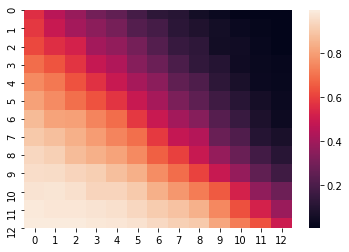

In [14]:
sns.heatmap(win_probs_move1)

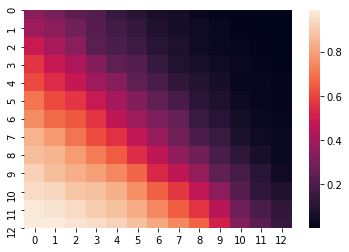

In [15]:
sns.heatmap(win_probs_move2)

In [24]:
print("Probabilities of winning if player 1 moves first:")
print(win_probs_move1)

Probabilities of winning if player 1 moves first:
[[0.56  0.456 0.38  0.296 0.253 0.182 0.122 0.105 0.056 0.031 0.008 0.006
  0.006]
 [0.581 0.489 0.408 0.354 0.304 0.221 0.183 0.118 0.087 0.055 0.033 0.015
  0.005]
 [0.616 0.56  0.523 0.405 0.365 0.301 0.222 0.148 0.124 0.052 0.046 0.025
  0.003]
 [0.69  0.64  0.577 0.487 0.437 0.338 0.277 0.197 0.134 0.102 0.044 0.027
  0.019]
 [0.755 0.715 0.638 0.567 0.49  0.413 0.351 0.251 0.208 0.12  0.072 0.032
  0.024]
 [0.808 0.757 0.694 0.636 0.574 0.49  0.411 0.315 0.246 0.169 0.108 0.06
  0.034]
 [0.868 0.812 0.805 0.743 0.693 0.581 0.494 0.403 0.34  0.226 0.154 0.079
  0.037]
 [0.904 0.883 0.841 0.797 0.743 0.696 0.587 0.481 0.443 0.273 0.21  0.102
  0.07 ]
 [0.945 0.924 0.872 0.842 0.812 0.754 0.663 0.603 0.488 0.372 0.274 0.177
  0.108]
 [0.96  0.954 0.937 0.919 0.88  0.842 0.76  0.693 0.607 0.49  0.374 0.25
  0.168]
 [0.975 0.98  0.966 0.934 0.935 0.907 0.843 0.786 0.723 0.651 0.525 0.362
  0.282]
 [0.99  0.983 0.983 0.974 0.965 0.945 0

In [25]:
print("Probabilities of winning if player 2 moves first:")
print(win_probs_move2)

Probabilities of winning if player 2 moves first:
[[0.351 0.298 0.238 0.21  0.146 0.104 0.07  0.056 0.03  0.008 0.007 0.002
  0.004]
 [0.385 0.344 0.283 0.223 0.177 0.133 0.084 0.06  0.039 0.025 0.007 0.005
  0.001]
 [0.487 0.406 0.341 0.233 0.195 0.16  0.108 0.076 0.039 0.023 0.013 0.006
  0.001]
 [0.57  0.486 0.421 0.331 0.241 0.223 0.141 0.089 0.065 0.042 0.023 0.011
  0.006]
 [0.615 0.545 0.479 0.392 0.337 0.242 0.19  0.127 0.09  0.061 0.019 0.018
  0.01 ]
 [0.702 0.616 0.569 0.487 0.398 0.331 0.247 0.187 0.113 0.077 0.033 0.016
  0.012]
 [0.755 0.68  0.643 0.568 0.463 0.384 0.316 0.257 0.148 0.106 0.059 0.028
  0.018]
 [0.841 0.785 0.701 0.62  0.563 0.469 0.376 0.289 0.199 0.148 0.073 0.038
  0.023]
 [0.871 0.847 0.788 0.718 0.65  0.551 0.467 0.358 0.275 0.192 0.124 0.064
  0.024]
 [0.92  0.868 0.835 0.796 0.744 0.67  0.539 0.467 0.368 0.243 0.179 0.105
  0.04 ]
 [0.944 0.935 0.887 0.877 0.833 0.76  0.656 0.577 0.47  0.344 0.223 0.125
  0.085]
 [0.976 0.967 0.944 0.905 0.878 0.828